In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sgkit as sg

from bokeh.plotting import show
from bokeh.io import output_notebook
from bokeh.models.widgets import RangeSlider

import sys
sys.path.append("../../tsimpute/src/")
import util
import vis

output_notebook()


Loading BokehJS ...

In [2]:
import os
os.environ["BOKEH_ALLOW_WS_ORIGIN"] = '0aaf0agotd3etfja916liv2etcl4ul9j3fk8kav1m1a16m18da6b'


In [3]:
# Genetic variation at shared sites
zarr_dir = "../data/zarr/"
ref_ds = sg.load_dataset(zarr_dir + "ref.zarr") # not all allele lists are ACGT
ref_ds_compat = sg.load_dataset(zarr_dir + "ref_compat.zarr")
target_ds_compat = sg.load_dataset(zarr_dir + "target_compat.zarr") # ground-truth
target_chip_ds_compat = sg.load_dataset(zarr_dir + "target_chip_compat.zarr")   # chip-like
lshmm_ds_compat = sg.load_dataset(zarr_dir + "beagle_like_2/" + "target_lshmm_compat.zarr")    # imputed
beagle_ds_compat = sg.load_dataset(zarr_dir + "target_beagle_compat.default.zarr")  # imputed


In [4]:
print(f"Sites in ref (full): {ref_ds.dims['variants']}")
print(f"Sites in ref (shared): {ref_ds_compat.dims['variants']}")
print(f"Sites in target (shared): {target_ds_compat.dims['variants']}")
print(f"Sites in target chip (shared): {target_chip_ds_compat.dims['variants']}")
print(f"Sites in lshmm (full): {lshmm_ds_compat.dims['variants']}")
print(f"Sites in BEAGLE (full): {beagle_ds_compat.dims['variants']}")


Sites in ref (full): 504314
Sites in ref (shared): 231630
Sites in target (shared): 231630
Sites in target chip (shared): 7899
Sites in lshmm (full): 504314
Sites in BEAGLE (full): 504314


In [5]:
# Identify chip and non-chip sites
chip_site_idx = np.where(np.isin(
    lshmm_ds_compat.variant_position.values,
    target_chip_ds_compat.variant_position.values,
))[0]

chip_site_idx_target = np.where(np.isin(
    target_ds_compat.variant_position.values,
    target_chip_ds_compat.variant_position.values,
))[0]

non_chip_site_idx = np.where(np.isin(
    lshmm_ds_compat.variant_position.values,
    target_chip_ds_compat.variant_position.values,
    invert=True,
))[0]

print(f"Chip sites: {len(chip_site_idx)}")
print(f"Chip sites (target): {len(chip_site_idx_target)}")
print(f"Non-chip sites: {len(non_chip_site_idx)}")


Chip sites: 7899
Chip sites (target): 7899
Non-chip sites: 496415


In [6]:
# Identify non-chip sites in both the truth dataset and BEAGLE-imputed dataset
non_chip_site_pos_in_truth = target_ds_compat.variant_position.values[np.isin(
    target_ds_compat.variant_position.values,
    target_chip_ds_compat.variant_position.values,  # Chip-like sites
    invert=True,
)]
non_chip_site_pos_in_beagle = beagle_ds_compat.variant_position.values[np.isin(
    beagle_ds_compat.variant_position.values,
    non_chip_site_pos_in_truth,
)]
assert np.array_equal(non_chip_site_pos_in_truth, non_chip_site_pos_in_beagle)


In [7]:
non_chip_site_idx_in_truth = np.where(np.isin(target_ds_compat.variant_position.values, non_chip_site_pos_in_truth))[0]
non_chip_site_idx_in_beagle = np.where(np.isin(beagle_ds_compat.variant_position.values, non_chip_site_pos_in_beagle))[0]

target_ds_non_chip_compat = target_ds_compat.isel(variants=non_chip_site_idx_in_truth)
beagle_ds_non_chip_compat = beagle_ds_compat.isel(variants=non_chip_site_idx_in_beagle)


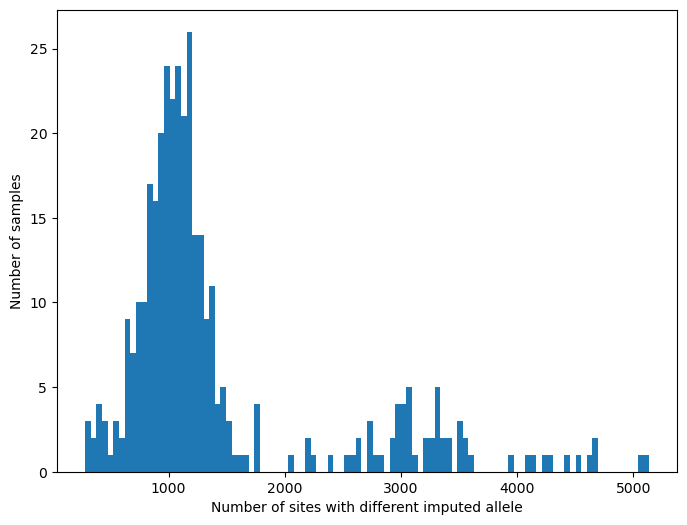

In [8]:
# Truth vs. BEAGLE (non-chip sites)
diff_truth_beagle = np.zeros(
    2 * target_ds_non_chip_compat.dims["samples"],
    dtype=np.int32
)

for i in np.arange(target_ds_compat.dims["samples"]):
    diff_truth_beagle[2 * i] = np.sum(np.invert(np.equal(
        target_ds_non_chip_compat.call_genotype[:, i, 0].values,
        beagle_ds_non_chip_compat.call_genotype[:, i, 0].values
    )))
    diff_truth_beagle[2 * i + 1] = np.sum(np.invert(np.equal(
        target_ds_non_chip_compat.call_genotype[:, i, 1].values,
        beagle_ds_non_chip_compat.call_genotype[:, i, 1].values
    )))

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(diff_truth_beagle, bins=100)
ax.set_ylabel("Number of samples")
ax.set_xlabel("Number of sites with different imputed allele");


In [9]:
# Identify non-chip sites in both the truth dataset and tskit-imputed dataset
non_chip_site_pos_in_tskit = lshmm_ds_compat.variant_position.values[np.isin(
    lshmm_ds_compat.variant_position.values,
    non_chip_site_pos_in_truth,
)]
assert np.array_equal(non_chip_site_pos_in_truth, non_chip_site_pos_in_tskit)


In [10]:
non_chip_site_idx_in_tskit = np.where(np.isin(lshmm_ds_compat.variant_position.values, non_chip_site_pos_in_tskit))[0]
tskit_ds_non_chip_compat = lshmm_ds_compat.isel(variants=non_chip_site_idx_in_tskit)


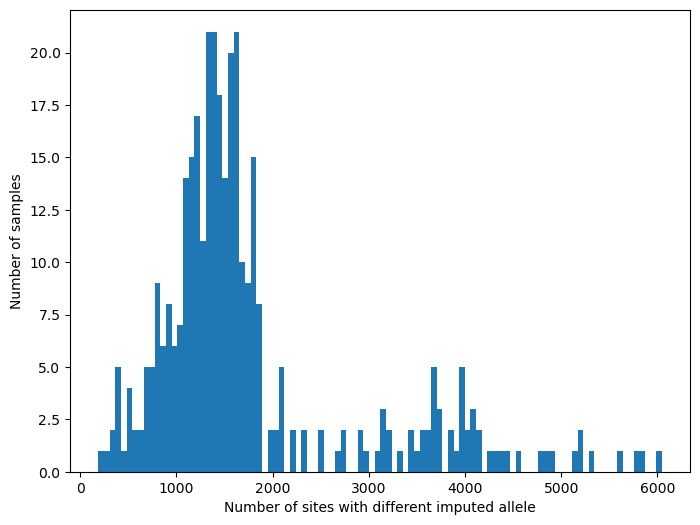

In [11]:
# Truth vs. tskit (non-chip sites)
diff_truth_tskit = np.zeros(
    2 * tskit_ds_non_chip_compat.dims["samples"],
    dtype=np.int32
)

for i in np.arange(target_ds_compat.dims["samples"]):
    diff_truth_tskit[2 * i] = np.sum(np.invert(np.equal(
        target_ds_non_chip_compat.call_genotype[:, i, 0].values,
        tskit_ds_non_chip_compat.call_genotype[:, i, 0].values
    )))
    diff_truth_tskit[2 * i + 1] = np.sum(np.invert(np.equal(
        target_ds_non_chip_compat.call_genotype[:, i, 1].values,
        tskit_ds_non_chip_compat.call_genotype[:, i, 1].values
    )))

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(diff_truth_tskit, bins=100)
ax.set_ylabel("Number of samples")
ax.set_xlabel("Number of sites with different imputed allele");


In [ ]:
# Choose a sample arbitrarily
focal_sample_id = np.where(diff_truth_tskit == np.min(diff_truth_tskit))[0][0]
print(np.min(diff_truth_tskit))
print(focal_sample_id)


In [ ]:
# Sample path (list of parent node ids)
h2 = np.load("../analysis/lshmm/" + "beagle_like_2/" + "h2_p25.npy")
h2.shape


In [ ]:
focal_sample_path = h2[focal_sample_id, :]
focal_sample_path.shape


In [ ]:
assert np.array_equal(
    beagle_ds_compat.variant_position.values[chip_site_idx],
    lshmm_ds_compat.variant_position.values[chip_site_idx],
)


In [ ]:
focal_individual_id = focal_sample_id // 2
focal_path_id = focal_sample_id % 2

tracks = [
    {
        'site_pos': beagle_ds_compat.variant_position[chip_site_idx].values,
        'site_base': beagle_ds_compat.call_genotype[chip_site_idx, focal_individual_id, focal_path_id].values,
    },
    {
        'site_pos': lshmm_ds_compat.variant_position[chip_site_idx].values,
        'site_base': lshmm_ds_compat.call_genotype[chip_site_idx, focal_individual_id, focal_path_id].values,
    },
    {
        'site_pos': target_ds_compat.variant_position[chip_site_idx_target].values,
        'site_base': target_ds_compat.call_genotype[chip_site_idx_target, focal_individual_id, focal_path_id].values,
    },
    {
        'site_pos': target_chip_ds_compat.variant_position.values,
        'site_base': np.repeat(-2, target_chip_ds_compat.dims["variants"]),
    },
]


In [ ]:
import tszip
ref_ts = tszip.decompress("../data/trees/ref.tsz")
ref_ts


In [ ]:
# TODO: Not actually used. Remove.
controls = {
    "interval": RangeSlider(
        start=0, end=len(focal_sample_path), step=1,
        value=(0, len(focal_sample_path)),
        title="Genomic interval"
    )
}

app = vis.create_sample_path_vis_app(
    path=util.SamplePath(
        individual="Focal sample",
        nodes=focal_sample_path[chip_site_idx],
        site_positions=ref_ts.sites_position[chip_site_idx],
    ),
    ts=ref_ts,
    tracks=tracks,
    legend_labels=[
        'BEAGLE',
        'tskit',
        'truth',
        'chip',
    ],
    controls=controls,
    range_node_id=(0, 1400),
    #range_site_pos=(5.80 * 10**6, 5.82 * 10**6),
)

show(app)


In [ ]:
pos_idx = 7539
print(ref_ts.sites_position[chip_site_idx][pos_idx])
print(ref_ds.call_genotype[:, 821 // 2, :].values[chip_site_idx][pos_idx])
